In [1]:
# Required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import sklearn.feature_selection
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay
import random as python_random


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from tensorflow.keras.models import Sequential

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_curve, classification_report, ConfusionMatrixDisplay

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

import tensorflow as tf
import keras.backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
import os

2024-04-14 14:05:28.480517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Data needs to loaded here by using the this function
def load_data(file):
    df = pd.read_csv(file)
    return df

data = load_data("Newdata-2.csv")
data

,Unauthorized


In [3]:
# function that calculates the percentage of transactions that belongs to the positive class
def data_distribution (df, target): 
    negative = len (df[df[target] ==0]) / len(df) * 100
    positive = len(df[df[target] ==1]) / len(df) * 100
    
    
    print("positive class: {} %".format(round(positive,2)))
    print("negative class: {} %".format(round(negative,2)))
   
# transaction might be different for another data 
data_distribution(data, "Transaction")   

positive class: 15.63 %
negative class: 84.37 %


In [4]:
# Encoding variables
def encode_strings(df, variable):
    dummies = pd.get_dummies(df[variable])
    new_data = pd.concat([df, dummies], axis = 1)
    new_data = new_data.drop([variable], axis = 1)
    return new_data

# encode Customer_Type
data = encode_strings(data, "Customer_Type")

def encode_boolean(df, variable):
    df[variable].replace({False: 0, True: 1}, inplace = True)
    return df

# convert weekday into 0 and 1
data = encode_boolean(data, "Weekday")

In [5]:
# Splitting data train/test
def split_data(df):
    train, test = train_test_split(df, test_size = 0.2, random_state = 101)
    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)
    return train, test

train, test = split_data(data)

In [6]:
# Splitting variables
def split_variables(df, target):
    X = df.drop(target, axis=1)
    y = df[target]
    return X, y

# variable transaction might be different for totally another data
X_train, y_train = split_variables(train, 'Transaction')

In [7]:
# Scaling variables 
def data_scaler(df):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

X_train = data_scaler(X_train)

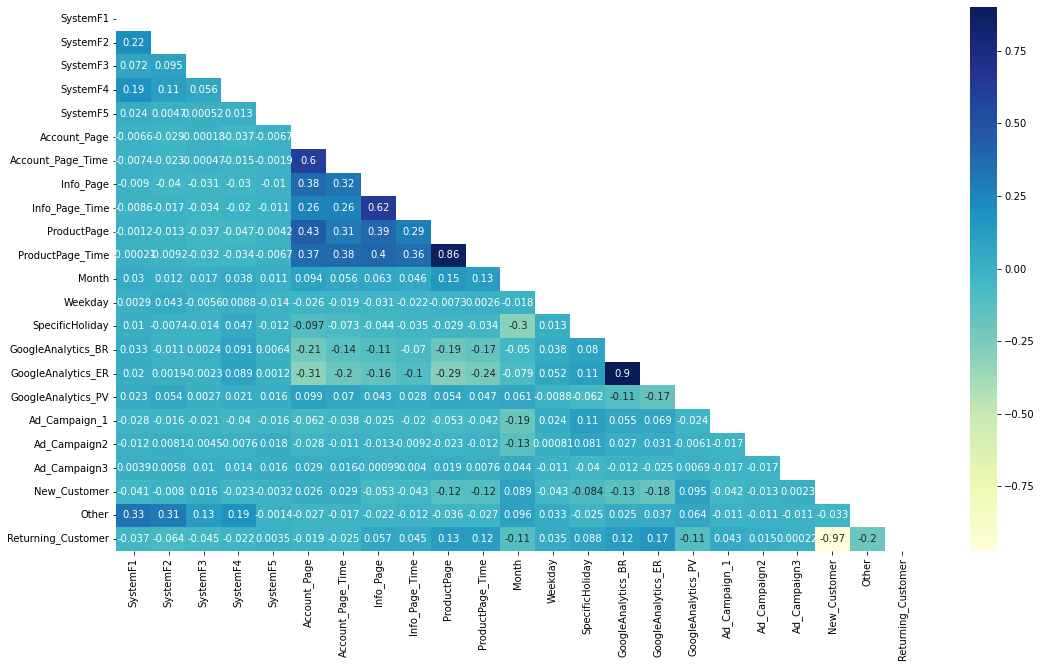

Ad_Campaign2 0.0
Ad_Campaign_1 0.0
Other 0.0005147793852155982
Ad_Campaign3 0.0021984170494720166
SpecificHoliday 0.003262178990558369
New_Customer 0.007708478608657547
Weekday 0.008899600689318372
Returning_Customer 0.011913990559679283
SystemF1 0.017140642426172734
SystemF2 0.023244933180589893
SystemF3 0.023599968223633944
SystemF5 0.033812728944470925
SystemF4 0.03527593941615449
Info_Page_Time 0.04086557952379738
Month 0.05397823218685979
Account_Page 0.06038748913364299
ProductPage 0.09694216450797265
GoogleAnalytics_ER 0.12806818187742006
GoogleAnalytics_PV 0.4521866952963838


In [8]:
# Feature selection

# functions that can be used to drop not needed features
def dropping(df, variable):
    df = df.drop(variable, axis = 1)
    return df

# Correlation matrix
def correlation_matrix(df):
    plt.rcParams["figure.figsize"] = (18,10)
    mask = np.triu(np.ones_like(df.corr()))
    dataplot = sns.heatmap(df.corr(), cmap = "YlGnBu", annot = True, mask = mask)
    return plt.show()

correlation_matrix(X_train)
X_train = dropping(X_train, ["GoogleAnalytics_BR", "ProductPage_Time", "Info_Page", "Account_Page_Time"])

# Decision tree with gini
def decision_trees(df, target):
    tree = DecisionTreeClassifier(random_state = 0).fit(df, target)
    for importance, features in sorted(zip(tree.feature_importances_, df.columns), reverse = False)[:]:
        print(features, importance)

decision_trees(X_train, y_train)
X_train = dropping(X_train, ["Ad_Campaign_1", "Other", "Ad_Campaign2", "SpecificHoliday", "Returning_Customer", "New_Customer", "Ad_Campaign3", "Weekday"])

In [9]:
# Model 1: K-Nearest Neighbors (baseline model)
seed_value= 0
np.random.seed(seed_value)
python_random.seed(seed_value)
tf.random.set_seed(seed_value)
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# Hyperparameter tuning:
# Source: https://www.kaggle.com/code/arunimsamudra/k-nn-with-hyperparameter-tuning

grid_params = {'n_neighbors': list(range(0, 30, 2)),
               'weights': ['uniform','distance'],
               'metric': ['minkowski','euclidean','manhattan']}

def knn_tuning(grid, X_train, y_train):
    cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 101)
    grid = RandomizedSearchCV(KNeighborsClassifier(), n_iter = 10, param_distributions = grid, cv = cv_outer, verbose = 0, scoring = "f1")
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    best_params = grid.best_params_
    best_score = grid.best_score_
    
    return best_model, best_params, best_score
   
# extract features that can be used later for predictions
best_model_knn, best_params_knn, best_score_knn = knn_tuning(grid_params, X_train.values, y_train)

In [10]:
# Functions for calculating the class weight
# Source: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
# Source: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

def weight (df, target): 
    negative_class, positive_class = np.bincount(df[target])
    total = negative_class + positive_class
    weight_positive_class = (1 / positive_class) * (total / 2)
    weight_negative_class = (1 / negative_class) * (total / 2)
    class_weight ={0: weight_negative_class, 1: weight_positive_class}
    return class_weight


# Transaction might be differnt for another data
class_weight = weight(train , "Transaction")

In [11]:
# Model 2: Logistic Regression (using weights, unbalanced data)

seed_value= 0
np.random.seed(seed_value)
python_random.seed(seed_value)
tf.random.set_seed(seed_value)
import os
os.environ['PYTHONHASHSEED']=str(seed_value)


param_grid = {'loss': ['log'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant','optimal','invscaling'],
    'eta0':[0.01, 0.1, 1.0]}

def logisticRegression(grid, X_train, y_train):
    model = SGDClassifier(class_weight=class_weight)
    cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 101)
    grid = RandomizedSearchCV(estimator = model, param_distributions = grid, cv = cv, scoring = 'f1', n_iter = 10, random_state = 101)
    r = grid.fit(X_train, y_train)
    
    best_model = r.best_estimator_
    best_params = r.best_params_
    best_score = r.best_score_
    
    return best_model, best_params, best_score, r

# extract features that can be used later for predictions
best_model_lr, best_params_lr, best_score_lr, r = logisticRegression(param_grid, X_train.values, y_train.values)

In [12]:
# Source: https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d

#function that calculates the f1 score
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [13]:
# Model 3: Neural Network
seed_value= 0
np.random.seed(seed_value)
python_random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)


# Function that trains a neural network
# Source: https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/
def neuralNetwork (hidden_1, hidden_2, learning_rate, dropout, metrics = f1, input_dim =X_train.shape[-1] ): 
    
    # sequential model to initialise  NN model
    model = Sequential()
    
    # input layer and the first hidden layer
    model.add(Dense(hidden_1, input_dim=input_dim, activation= "relu", kernel_initializer = "normal"))
    
    # insert dropout after the first hidden laye
    model.add (Dropout(dropout))
    
    # second hidden layer
    model.add(Dense(hidden_2, activation= "relu", kernel_initializer = "normal")) 
    
    # output layer: 1, because of binary classification
    model.add(Dense(units=1, activation="sigmoid"))
    
    # compiling the model binary_crossentropy because it is binary classification
    model.compile(loss='binary_crossentropy', optimizer= "Adam", metrics = f1)

    return model

# dictionary that can be used stored parameters that can be tuned
param_grid = dict(hidden_1=[5,10, 15, 20,25,30],
             hidden_2 =[5,10,15, 20,25,30],
              learning_rate=np.linspace(0.1, 1),
              dropout=np.linspace(0, 0.1),
              batch_size=list(range(180, 400, 1)),
              epochs=[40, 60,80,100, 120] )

# Functions that grid searchs the best parameters
def grid_search_NN (X_train, y_train, model, paramGrid, class_weight): 
    model = KerasClassifier(build_fn=model, verbose = 0)
    cv= StratifiedKFold(n_splits=10, shuffle=True, random_state=101)
    grid = RandomizedSearchCV(estimator=model, n_iter=1, n_jobs=1, cv = cv,
                              param_distributions = paramGrid, scoring="f1")
    
    # fit the model
    training_validation_result = grid.fit(X_train, y_train, class_weight = class_weight)
    
   
    
    # model results
    best_model = training_validation_result.best_estimator_
    best_params = training_validation_result.best_params_
    best_score = training_validation_result.best_score_
    

    return best_model, best_params, best_score, training_validation_result

# Extract the model and the best parameters (for predictions)
best_model_NN, best_params_NN, best_score_NN, result=(grid_search_NN(X_train, y_train, neuralNetwork,param_grid, class_weight = class_weight))


31/31 [==============================] - 0s 3ms/step


In [14]:
# Preprocessing test data; split + scale test so that it has the same 
X_test, y_test = split_variables(test, 'Transaction')
X_test = data_scaler(X_test)

# variables that need to be dropped might be different for totally other data
X_test = dropping(X_test, ["GoogleAnalytics_BR", "ProductPage_Time", "Info_Page", "Account_Page_Time", "Ad_Campaign_1", "Other", "Ad_Campaign2", "SpecificHoliday", "Returning_Customer", "New_Customer", "Ad_Campaign3", "Weekday"])

#knn predictions
KNN_predictions =best_model_knn.predict(X_test)

# neural network predicitons
NN_predictions =best_model_NN.predict(X_test)

# logistic regression prediction
LR_predictions =best_model_lr.predict(X_test)


# Function that can be used to convert predictions and ground truth csv
def predictions_csv(y_test, KNN_predictions, LR_predictions, NN_predictions): 
    
    # preprocessing ground truth data
    Ground_truth = pd.DataFrame(y_test)
    Ground_truth.index = Ground_truth.index
    Ground_truth.columns = ["Ground truth"]
    
    # preprocessing knn predictions
    knn = pd.DataFrame(KNN_predictions)
    knn.index = knn.index 
    knn.columns = ["KNN_predictions"]
    
    # preprocessing Logistic Regression predictions
    LR = pd.DataFrame(LR_predictions)
    LR.index = LR.index 
    LR.columns = ["LR_predictions"]
    
    # preprocessing Neural Network predictions
    NN = pd.DataFrame(NN_predictions)
    NN.index = NN.index 
    NN.columns = ["NN_predictions"]
    
    # combine all them
    result = pd.concat([Ground_truth,knn, LR, NN], axis = 1, join = "inner")
    result.to_csv("Predictions.csv")
    
# save predictions of the models into csv 
predictions_csv(y_test,KNN_predictions, LR_predictions, NN_predictions)

77/77 [==============================] - 0s 2ms/step


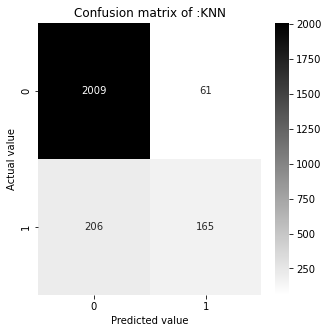

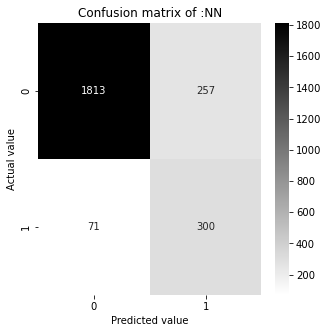

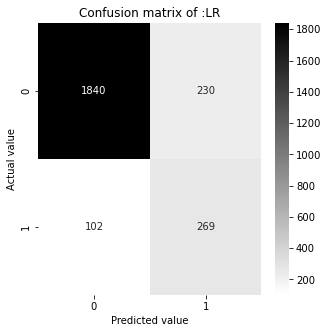

In [15]:
#Function that plots the confusion matrix
#Source: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

def plot_confusion_matrix (y_test, y_predictions, model_name): 
    matrix = confusion_matrix(y_test, y_predictions)
    plt.figure(figsize= (5,5))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="binary")
    plt.title("Confusion matrix of :" + model_name)
    plt.ylabel("Actual value")
    plt.xlabel("Predicted value")
    
    
plot_confusion_matrix(y_test, KNN_predictions, "KNN")
plot_confusion_matrix(y_test, NN_predictions, "NN")
plot_confusion_matrix(y_test, LR_predictions, "LR")

In [16]:
#function that calculates f1, precision and recall
def performance_report(y_test, y_predicions): 
    f1 = f1_score(y_test, y_predicions)
    precision = precision_score(y_test, y_predicions)
    recall = recall_score(y_test, y_predicions)
    
    return precision, recall, f1

precision_knn, recall_knn, f1_knn = performance_report(y_test, KNN_predictions)
precision_lr, recall_lr, f1_lr = performance_report(y_test, LR_predictions)
precision_nn, recall_nn, f1_nn = performance_report(y_test, NN_predictions)
print(precision_knn, recall_knn, f1_knn)
print(precision_lr, recall_lr, f1_lr)
print(precision_nn, recall_nn, f1_nn)

0.7300884955752213 0.444743935309973 0.5527638190954773
0.5390781563126252 0.7250673854447439 0.618390804597701
0.5385996409335727 0.8086253369272237 0.646551724137931
